In [32]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv

from tqdm import tqdm
import haversine as hs
import networkx as nx

device = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 42
torch.manual_seed(seed)
torch.random.manual_seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'

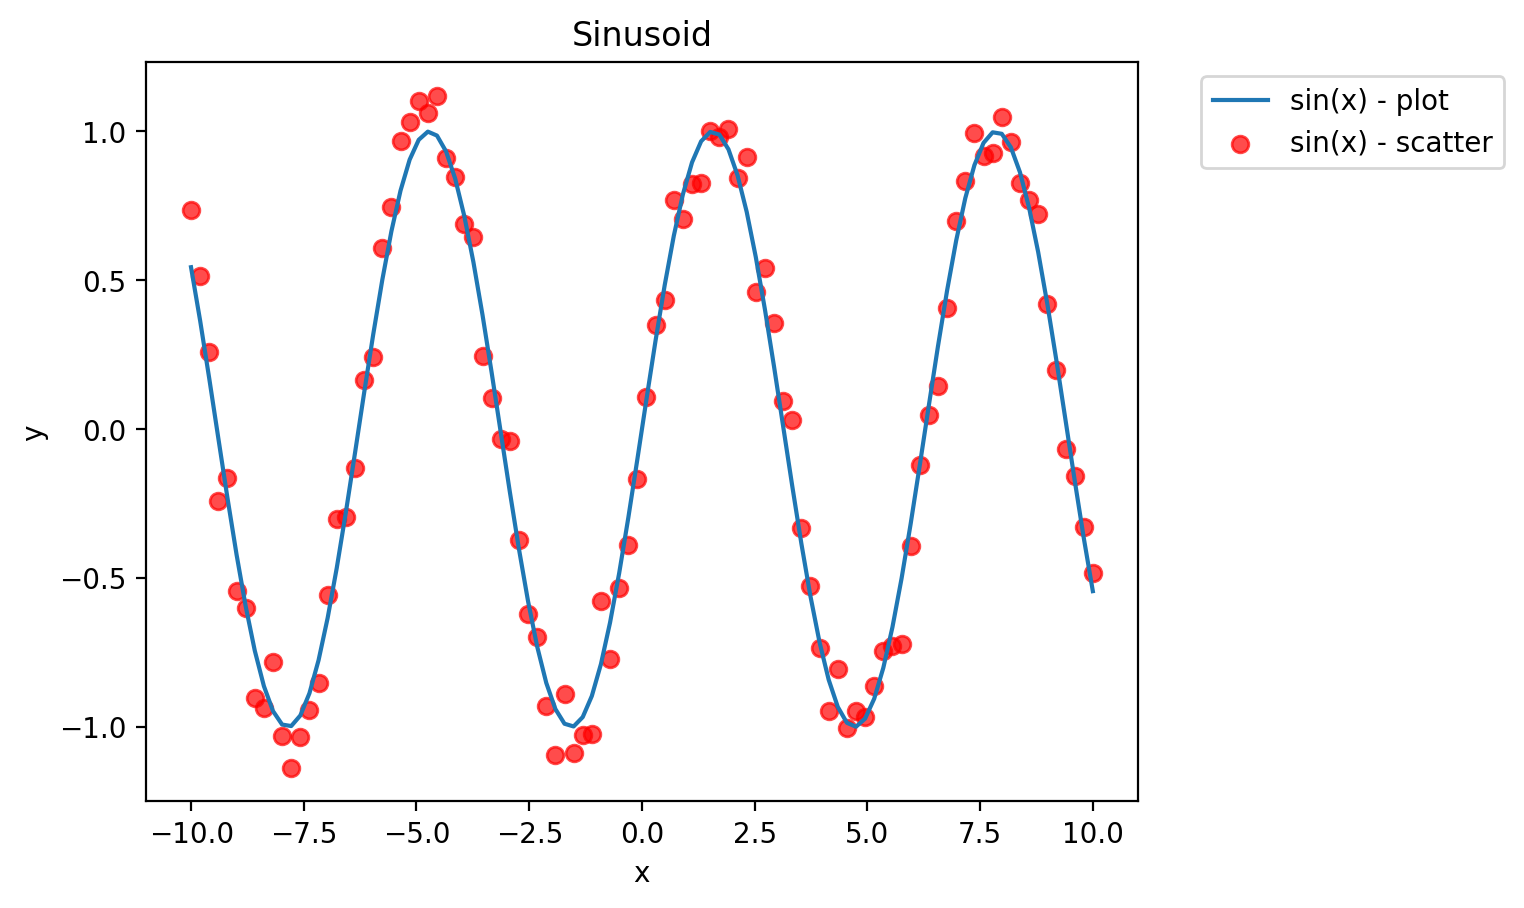

In [33]:
n_points = 100

x = torch.linspace(-10, 10, n_points)


y = torch.sin(x) + torch.randn(n_points) * 0.1
plt.plot(x, torch.sin(x) );
plt.scatter(x, y, c = 'red', alpha = 0.7);
plt.title('Sinusoid');
plt.xlabel('x');
plt.ylabel('y');
plt.legend(['sin(x) - plot', 'sin(x) - scatter'],bbox_to_anchor=(1.05, 1.0), loc='upper left');

In [34]:
x = StandardScaler().fit_transform(x.reshape(-1, 1))
y = StandardScaler().fit_transform(y.reshape(-1, 1))
x = torch.tensor(x, dtype=torch.float32).squeeze()
y = torch.tensor(y, dtype=torch.float32).squeeze()

In [35]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.4)

In [42]:
def graph_attr(n_points):
    edge_index = []
    edge_weight = []
    for i in range(n_points):
        for j in range(n_points):
            if i != j:
                edge_index.append([i, j])
                edge_weight.append(abs(i-j))
            if i == j:
                edge_index.append([i, j])
                edge_weight.append()

    return torch.tensor(edge_index).T, torch.tensor(edge_weight, dtype=torch.float32)

In [43]:
edge_index, edge_weight = graph_attr(n_points)

In [44]:
train_mask = torch.zeros(x.shape[0], dtype=torch.bool)
test_mask = torch.zeros(x.shape[0], dtype=torch.bool)
for i in range(x.shape[0]):
    if x[i] in train_x:
        train_mask[i] = True
    else:
        test_mask[i] = True

In [45]:
data = Data(x=x, edge_index=edge_index,edge_weights = edge_weight, y=y, train_mask=train_mask, test_mask=test_mask).to(device)

In [46]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.conv1 = GCNConv(input_dim, 32)
        self.linear1 = nn.Linear(32, 16)
        self.linear2 = nn.Linear(16, 1)

    def forward(self, x, edge_index, edge_weights):
        x = self.conv1(x, edge_index, edge_weights)
        x = F.relu(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

100%|██████████| 5000/5000 [00:17<00:00, 284.71it/s]


Train RMSE 0.29180944
Test RMSE 0.3395961


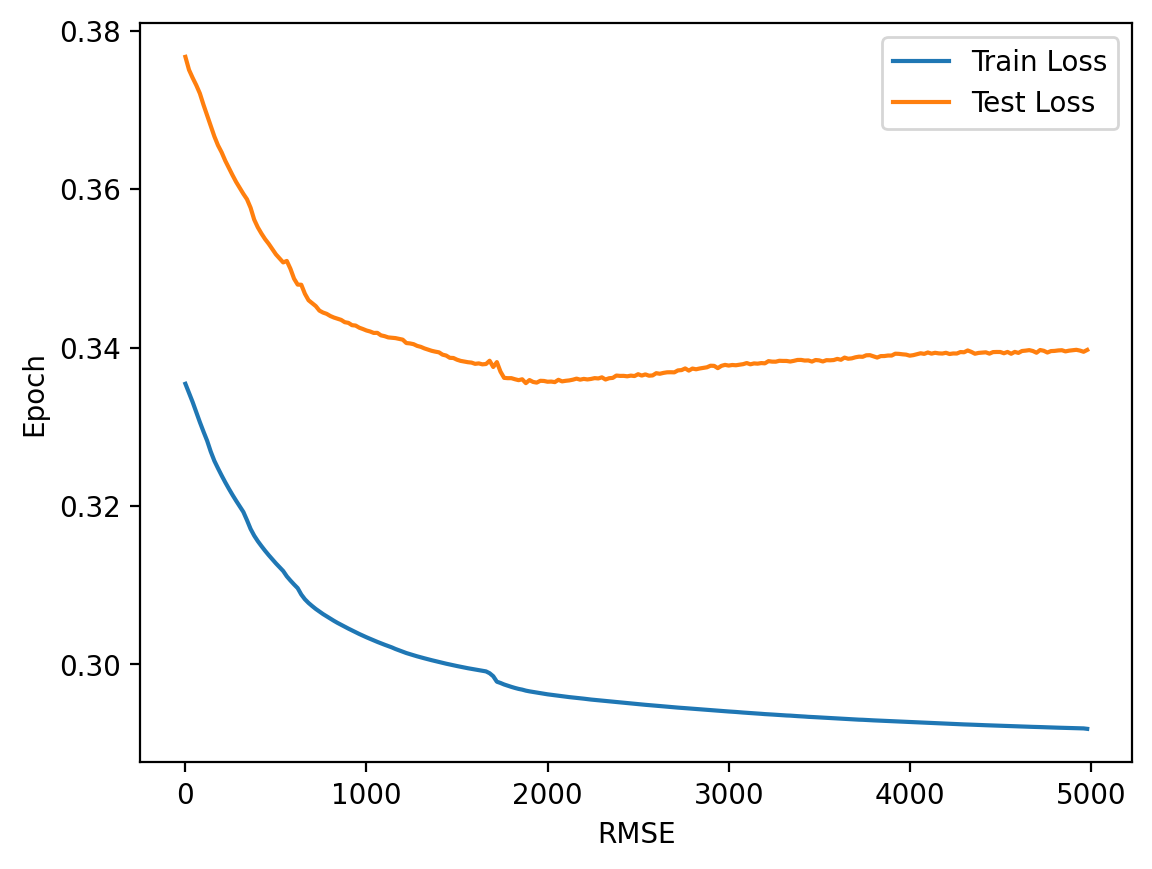

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = RegressionModel(input_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

train_rmse_list = []
test_rmse_list = []

for epoch in tqdm(range(5000)):
    optimizer.zero_grad()
    out = model(data.x.unsqueeze(1).to(device), data.edge_index.to(device), data.edge_weights.to(device))
    loss = criterion(out[data.train_mask].squeeze(), data.y[data.train_mask].squeeze())
    loss.backward()
    optimizer.step()
    if(epoch%20==0):
        model.eval()
        with torch.no_grad():
            out = model(data.x.unsqueeze(1).to(device), data.edge_index.to(device),data.edge_weights.to(device))  # Predicted PM values
            train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
            test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
            train_rmse_list.append(train_rmse.item())
            test_rmse_list.append(test_rmse.item())
        model.train()

model.eval()
with torch.no_grad():
    out = model(data.x.unsqueeze(1).to(device), data.edge_index.to(device),data.edge_weights.to(device))  # Predicted PM values
    train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
    test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
    print("Train RMSE", train_rmse.cpu().numpy())
    print("Test RMSE", test_rmse.cpu().numpy())        

plt.plot(range(0, 20*len(train_rmse_list), 20), train_rmse_list, label='Train Loss')
plt.plot(range(0, 20*len(test_rmse_list), 20), test_rmse_list, label='Test Loss')
plt.xlabel('RMSE')
plt.ylabel('Epoch')
plt.legend()
plt.show()

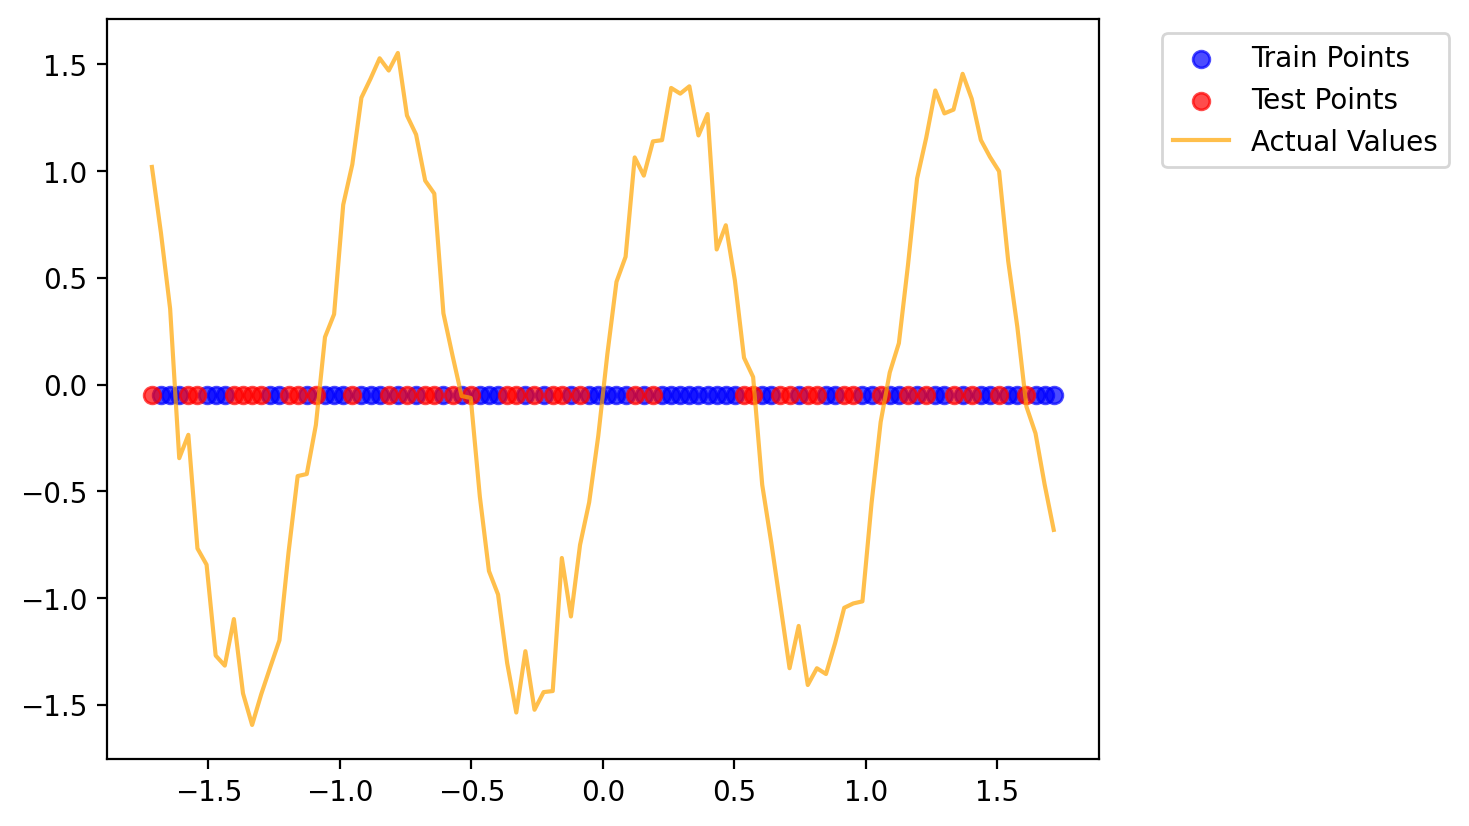

In [52]:
out = model(data.x.unsqueeze(1).to(device), data.edge_index.to(device),data.edge_weight)  # Predicted PM values
train_preds = out[data.train_mask].cpu().squeeze().detach().numpy()
test_preds = out[data.test_mask].cpu().squeeze().detach().numpy()

plt.scatter(data.x[data.train_mask].cpu(), train_preds, color = 'blue', label = 'Train Points', alpha = 0.7)
plt.scatter(data.x[data.test_mask].cpu(), test_preds, color = 'red', label = 'Test Points',alpha = 0.7)
plt.plot(x, y, label = 'Actual Values', color = 'orange', alpha = 0.7)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()